# Evaluating the Ideal Chunk Size for a RAG System using LlamaIndex

# **Introduction**

Retrieval-augmented generation (RAG) has introduced an innovative approach that fuses the extensive retrieval capabilities of search systems with the LLM. When implementing a RAG system, one critical parameter that governs the system’s efficiency and performance is the `chunk_size`. How does one discern the optimal chunk size for seamless retrieval? This is where LlamaIndex `Response Evaluation` comes handy. In this blogpost, we'll guide you through the steps to determine the best `chunk size` using LlamaIndex’s `Response Evaluation` module. If you're unfamiliar with the `Response` Evaluation module, we recommend reviewing its [documentation](https://docs.llamaindex.ai/en/latest/core_modules/supporting_modules/evaluation/modules.html) before proceeding.

## **Why Chunk Size Matters**

Choosing the right `chunk_size` is a critical decision that can influence the efficiency and accuracy of a RAG system in several ways:

1. **Relevance and Granularity**: A small `chunk_size`, like 128, yields more granular chunks. This granularity, however, presents a risk: vital information might not be among the top retrieved chunks, especially if the `similarity_top_k` setting is as restrictive as 2. Conversely, a chunk size of 512 is likely to encompass all necessary information within the top chunks, ensuring that answers to queries are readily available. To navigate this, we employ the Faithfulness and Relevancy metrics. These measure the absence of ‘hallucinations’ and the ‘relevancy’ of responses based on the query and the retrieved contexts respectively.
2. **Response Generation Time**: As the `chunk_size` increases, so does the volume of information directed into the LLM to generate an answer. While this can ensure a more comprehensive context, it might also slow down the system. Ensuring that the added depth doesn't compromise the system's responsiveness is crucial.

In essence, determining the optimal `chunk_size` is about striking a balance: capturing all essential information without sacrificing speed. It's vital to undergo thorough testing with various sizes to find a configuration that suits the specific use-case and dataset.

## **Setup**

Before embarking on the experiment, we need to ensure all requisite modules are imported:

In [1]:
# !pip install llama-index pypdf

In [1]:
import nest_asyncio
nest_asyncio.apply()
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    ServiceContext
)
from llama_index.core.evaluation import (
    DatasetGenerator,
    FaithfulnessEvaluator,
    RelevancyEvaluator
)
from llama_index.llms.openai import OpenAI
import time
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_KEY=os.environ["OPENAI_API_KEY"]

## **Download Data**

We'll be using the Uber 10K SEC Filings for 2021 for this experiment.

In [3]:
# !mkdir -p 'data/10k/'
# !wget 'https://raw.githubusercontent.com/jerryjliu/llama_index/main/docs/examples/data/10k/uber_2021.pdf' -O 'data/10k/uber_2021.pdf'

## **Load Data**

Let’s load our document.

In [2]:
# Load Data

reader = SimpleDirectoryReader("./data/10k")
documents = reader.load_data()

## **Question Generation**

To select the right `chunk_size`, we'll compute metrics like Average Response time, Faithfulness, and Relevancy for various `chunk_sizes`. The `DatasetGenerator` will help us generate questions from the documents.

In [3]:
# To evaluate for each chunk size, we will first generate a set of 40 questions from first 20 pages.
eval_documents = documents
data_generator = DatasetGenerator.from_documents(eval_documents)
eval_questions = data_generator.generate_questions_from_nodes(num = 40)

/home/babi/miniconda3/envs/week10/lib/python3.8/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/babi/miniconda3/envs/week10/lib/python3.8/site-packages/torch/cuda/__init__.py:758: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
/home/babi/miniconda3/envs/week10/lib/python3.8/site-packages/llama_index/core/evaluation/dataset_generation.py:212: DeprecationWarning: Call to deprecated class DatasetGenerator. (Deprecated in favor of `RagDatasetGenerator` which should be use

## Setting Up Evaluators

We are setting up the GPT-4 model to serve as the backbone for evaluating the responses generated during the experiment. Two evaluators, `FaithfulnessEvaluator` and `RelevancyEvaluator`, are initialised with the `service_context` .

1. **Faithfulness Evaluator** - It is useful for measuring if the response was hallucinated and measures if the response from a query engine matches any source nodes.
2. **Relevancy Evaluator** - It is useful for measuring if the query was actually answered by the response and measures if the response + source nodes match the query.

In [4]:
# We will use GPT-4 for evaluating the responses
gpt4 = OpenAI(temperature=0, model="gpt-4")

# Define service context for GPT-4 for evaluation
service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)

# Define Faithfulness and Relevancy Evaluators which are based on GPT-4
faithfulness_gpt4 = FaithfulnessEvaluator(service_context=service_context_gpt4)
relevancy_gpt4 = RelevancyEvaluator(service_context=service_context_gpt4)


/tmp/ipykernel_437780/2600024486.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)


## **Response Evaluation For A Chunk Size**

We evaluate each chunk_size based on 3 metrics.

1. Average Response Time.
2. Average Faithfulness.
3. Average Relevancy.

Here's a function, `evaluate_response_time_and_accuracy`, that does just that which has:

1. VectorIndex Creation.
2. Building the Query Engine**.**
3. Metrics Calculation.

In [5]:
# Define function to calculate average response time, average faithfulness and average relevancy metrics for given chunk size
# We use GPT-3.5-Turbo to generate response and GPT-4 to evaluate it.
def evaluate_response_time_and_accuracy(chunk_size, eval_questions, chunk_overlap):
    """
    Evaluate the average response time, faithfulness, and relevancy of responses generated by GPT-3.5-turbo for a given chunk size.

    Parameters:
    chunk_size (int): The size of data chunks being processed.

    Returns:
    tuple: A tuple containing the average response time, faithfulness, and relevancy metrics.
    """

    total_response_time = 0
    total_faithfulness = 0
    total_relevancy = 0

    # create vector index
    llm = OpenAI(model="gpt-3.5-turbo")
    service_context = ServiceContext.from_defaults(llm=llm, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    vector_index = VectorStoreIndex.from_documents(
        eval_documents, service_context=service_context
    )
    # build query engine
    # By default, similarity_top_k is set to 2. To experiment with different values, pass it as an argument to as_query_engine()
    query_engine = vector_index.as_query_engine()
    num_questions = len(eval_questions)

    # Iterate over each question in eval_questions to compute metrics.
    # While BatchEvalRunner can be used for faster evaluations (see: https://docs.llamaindex.ai/en/latest/examples/evaluation/batch_eval.html),
    # we're using a loop here to specifically measure response time for different chunk sizes.
    for question in eval_questions:
        start_time = time.time()
        response_vector = query_engine.query(question)
        elapsed_time = time.time() - start_time

        faithfulness_result = faithfulness_gpt4.evaluate_response(
            response=response_vector
        ).passing

        relevancy_result = relevancy_gpt4.evaluate_response(
            query=question, response=response_vector
        ).passing

        total_response_time += elapsed_time
        total_faithfulness += faithfulness_result
        total_relevancy += relevancy_result

    average_response_time = total_response_time / num_questions
    average_faithfulness = total_faithfulness / num_questions
    average_relevancy = total_relevancy / num_questions

    return average_response_time, average_faithfulness, average_relevancy

## **Testing Across Different Chunk Sizes**

We'll evaluate a range of chunk sizes to identify which offers the most promising metrics

In [6]:
chunk_sizes = [128, 256, 512, 1024, 2048]

for chunk_size in chunk_sizes:
  chunk_overlap = chunk_size // 2  # Adjust chunk_overlap based on chunk_size
  avg_response_time, avg_faithfulness, avg_relevancy = evaluate_response_time_and_accuracy(chunk_size, eval_questions, chunk_overlap)
  print(f"Chunk size {chunk_size} - Average Response time: {avg_response_time:.2f}s, Average Faithfulness: {avg_faithfulness:.2f}, Average Relevancy: {avg_relevancy:.2f}")

/tmp/ipykernel_437780/1701618581.py:20: DeprecationWarning: Call to deprecated function (or staticmethod) from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(llm=llm, chunk_size=chunk_size, chunk_overlap=chunk_overlap)


Chunk size 128 - Average Response time: 1.64s, Average Faithfulness: 0.97, Average Relevancy: 0.97
Chunk size 256 - Average Response time: 1.86s, Average Faithfulness: 0.93, Average Relevancy: 0.95
Chunk size 512 - Average Response time: 2.14s, Average Faithfulness: 0.97, Average Relevancy: 1.00
Chunk size 1024 - Average Response time: 1.91s, Average Faithfulness: 0.97, Average Relevancy: 1.00
Chunk size 2048 - Average Response time: 2.95s, Average Faithfulness: 0.30, Average Relevancy: 0.40


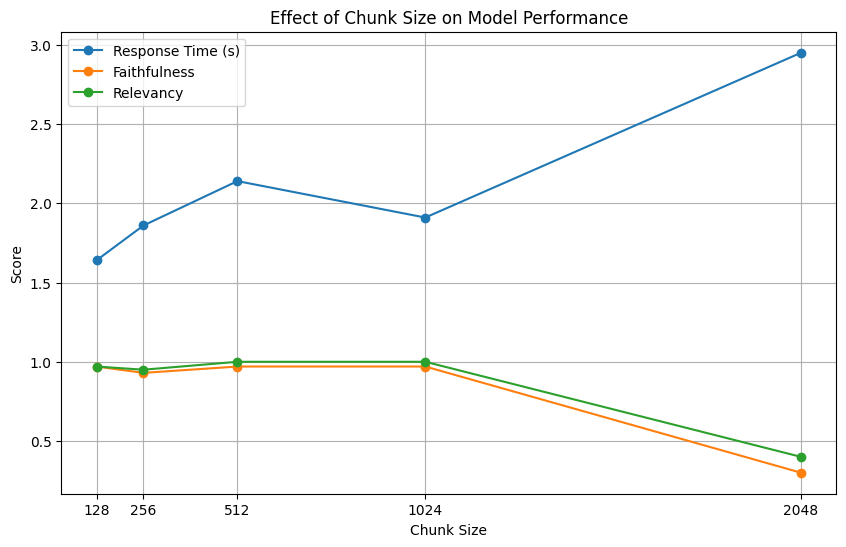

In [7]:
import matplotlib.pyplot as plt

# Data
chunk_sizes = [128, 256, 512, 1024, 2048]
response_times = [1.64, 1.86, 2.14, 1.91, 2.95]
faithfulness_scores = [0.97, 0.93, 0.97, 0.97, 0.30]
relevancy_scores = [0.97, 0.95, 1.00, 1.00, 0.40]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(chunk_sizes, response_times, marker='o', label='Response Time (s)')
plt.plot(chunk_sizes, faithfulness_scores, marker='o', label='Faithfulness')
plt.plot(chunk_sizes, relevancy_scores, marker='o', label='Relevancy')

plt.xlabel('Chunk Size')
plt.ylabel('Score')
plt.title('Effect of Chunk Size on Model Performance')
plt.xticks(chunk_sizes)
plt.legend()
plt.grid(True)

plt.show()
